In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [27]:
import os
import torch
import nibabel as nib
import numpy as np
from monai.inferers import sliding_window_inference
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, CropForegroundd, ScaleIntensityRanged, Rotate90, Rotate90d, ToTensord,
    AsDiscrete, Compose
)
from monai.data import Dataset, DataLoader, decollate_batch
from utils import get_model  # Ensure this function is available for loading your model

# Set up inference parameters
MODEL_CHECKPOINT = "/content/models/bel_old/best_metric_awc_64-0.87.ckpt"  # Update with your model path
INPUT_IMAGE_DIR = "/content/data_samples/imagesTr/"  # Directory containing NIfTI images
INPUT_LUNG_DIR = "/content/data_samples/lungsTr/"  # Directory containing NIfTI lung masks
OUTPUT_DIR = "/content/data_samples/predsTr/"  # Where to save results
PATCH_SIZE = (256, 256, 256)  # Update as needed
BATCH_SIZE = 1  # Adjust based on available memory
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params_dict = {
    'PATCH_SIZE': (PATCH_SIZE, PATCH_SIZE, PATCH_SIZE),
    'BATCH_SIZE': 1,
    'MAX_CARDINALITY': 120,
    'NUM_WORKERS': 0,
    'PIN_MEMORY': True,
    'AVAILABLE_GPUs': torch.cuda.device_count(),
}
params={"MODEL_NAME": "AttentionUNet",
        "IN_CHANNELS": 1,
        "OUT_CHANNELS": 1,
        "CHANNELS": 16,
        "N_LAYERS": 5,
        "STRIDES": 2,
        "SPATIAL_DIMS": 3,
        "DROPOUT": 0.0
        }
# Load the trained model
print("Loading model...")
model = get_model(params)  # Adjust params
print(model)
# Load the checkpoint
checkpoint = torch.load(MODEL_CHECKPOINT, map_location=DEVICE)

# Modify the state_dict to remove "_model." prefix from keys
new_state_dict = {}
for key, value in checkpoint["state_dict"].items():
    new_key = key.replace("_model.", "")  # Remove the prefix
    new_state_dict[new_key] = value

# Load the modified state_dict into the model
model.load_state_dict(new_state_dict, strict=False)
model.to(DEVICE)
model.eval()

# Define preprocessing pipeline using Compose
preprocess = Compose([
    LoadImaged(keys=["image", "lung"], image_only=False),
    EnsureChannelFirstd(keys=["image", "lung"]),
    CropForegroundd(keys=["image", "lung"], source_key="lung", margin=[1, 1, 50], allow_smaller=True),
    ScaleIntensityRanged(
        keys="image",
        a_min=-1000,  # Adjust based on your dataset
        a_max=600,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),
    Rotate90d(keys=["image", "lung"], k=3),
    ToTensord(keys=["image", "lung"], dtype=torch.float32),
])

# Define post-processing pipeline
post_pred = Compose([
            AsDiscrete(threshold=0.5),
            Rotate90(k=1, spatial_axes=(0, 1))
        ])
# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# List all NIfTI files
image_files = [f for f in os.listdir(INPUT_IMAGE_DIR) if f.endswith(".nii") or f.endswith(".nii.gz")]

# Create dataset for preprocessing
data_list = []
for file in image_files:
    image_path = os.path.join(INPUT_IMAGE_DIR, file)
    lung_path = os.path.join(INPUT_LUNG_DIR, file)  # Assumes lung mask has the same filename
    if os.path.exists(lung_path):
        data_list.append({"image": image_path, "lung": lung_path})
    else:
        print(f"Skipping {file}: Corresponding lung mask not found.")

# Create DataLoader
dataset = Dataset(data=data_list, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=1, num_workers=4)

print(f"Found {len(dataset)} NIfTI cases. Running inference...")

# Perform inference on each file
with torch.no_grad():
    for batch in dataloader:
        file_name = os.path.basename(batch["image_meta_dict"]["filename_or_obj"][0])  # Extract filename

        # Move tensors to device
        input_tensor = batch["image"].to(DEVICE)

        # Run model inference
        output_tensor = sliding_window_inference(
            inputs=input_tensor, roi_size=PATCH_SIZE, sw_batch_size=BATCH_SIZE, predictor=model, overlap=0.25
        )
        tst_outputs = [post_pred(i) for i in decollate_batch(output_tensor)]
        tst_filename = batch['image_meta_dict']['filename_or_obj'][0].split('/')[-1].split('.')[0]
        affine = batch['image_meta_dict']['affine'][0]
        spt_size = batch['image_meta_dict']['spatial_shape'][0].tolist()
        x1, x2, x3 = batch['foreground_start_coord'][0][0], batch['foreground_start_coord'][0][1], \
            batch['foreground_start_coord'][0][2]
        y1, y2, y3 = batch['foreground_end_coord'][0][0], batch['foreground_end_coord'][0][1], \
            batch['foreground_end_coord'][0][2]

        output_corr = np.zeros(spt_size)
        label_corr = np.zeros(spt_size)

        output_corr[x1:y1, x2:y2, x3:y3] = np.squeeze(tst_outputs[0].type(torch.int64).cpu().numpy())


        # Load original NIfTI to keep affine and header
        original_nifti = nib.load(batch["image_meta_dict"]["filename_or_obj"][0])

        # Save the predicted segmentation
        output_nifti = nib.Nifti1Image(output_corr, affine=affine, header=original_nifti.header)
        output_path = os.path.join(OUTPUT_DIR, file_name)
        nib.save(output_nifti, output_path)

        print(f"Saved: {output_path}")

print("Inference completed.")

Loading model...
AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv3d(16, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          )
          (1): BatchNo

<ipython-input-27-bb979720d23a>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_CHECKPOINT, map_location=DEVICE)


Found 3 NIfTI cases. Running inference...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Saved: /content/data_samples/predsTr/ATM_001_0000.nii.gz
Saved: /content/data_samples/predsTr/ATM_002_0000.nii.gz
Saved: /content/data_samples/predsTr/ATM_004_0000.nii.gz
Inference completed.


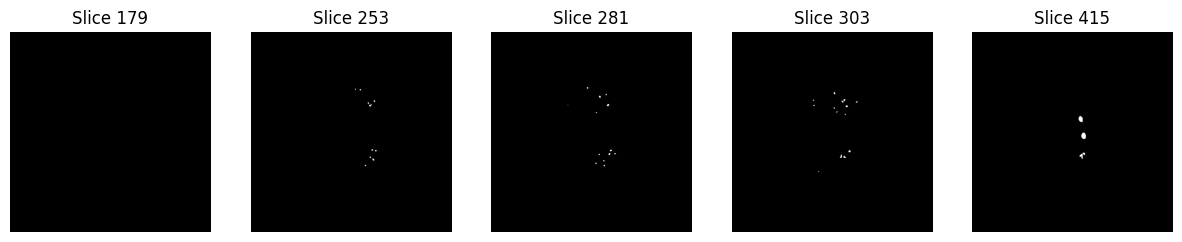

In [28]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random

# Load NIfTI file
nii_path = "/content/data_samples/predsTr/ATM_001_0000.nii.gz"
nifti_img = nib.load(nii_path)
nifti_data = nifti_img.get_fdata()

# Get shape of the volume
depth = nifti_data.shape[2]  # Assuming the 3rd axis is the depth

# Select random slices
num_slices = 5  # Number of slices to visualize
random_slices = sorted(random.sample(range(depth), num_slices))

# Plot the selected slices
fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
for i, slice_idx in enumerate(random_slices):
    axes[i].imshow(nifti_data[:, :, slice_idx], cmap="gray")
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis("off")

plt.show()